In [1]:
import numpy as np
from scipy import signal
import json
from utilities import *
from utilitiesDL import *
from OFDMparam import *
from CFOcorr import *
from getModFeat import *
import random
import os
from glob import glob
from collections import defaultdict

import torch
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
pi = math.pi

/home/byk004/miniconda3/envs/cyclo_modul_OFDM/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
imgSizePsk = 15
imgSizeQam = 50
coord = 'sph'

SNRVec = np.arange(5, 46, 5, dtype=int)
trainMode = 'test' # {test, train}

inputSampRate = 20e6
longestPreambleLen = 0
dataSamplingRate = 30.72e6
inputNHalfSubfr = 6
nSymFeatNR = 5

lenHalfSubfr = int(0.5e-3 * dataSamplingRate)
removeNull = True
angleMod = True

inputJson = './inputJson/testNR.json'
classJson = './inputJson/class/testClassNR.json'

f = open(inputJson)
dataPath = json.load(f)['data_path']
print(dataPath)

fClass = open(classJson)
classJson = json.load(fClass)

protocolList = np.array(classJson['protocolList'])
CPOptList = np.array(classJson['CPOptList'], dtype=object)
CPLenList = np.array(classJson['CPLenList'], dtype=object)
modList = np.array(classJson['modList'], dtype=object)

/project/iarpa/dataset/cyclo_modul_OFDM/simulation/train/test/


In [6]:
dataDict = {file:[] for file in protocolList}
for i, protocol in enumerate(protocolList):
    dataDict[protocol] = {file:[] for file in CPOptList[i]}
    for CPOpt in CPOptList[i]:
        dataDict[protocol][CPOpt] = {file:[] for file in modList[i]}
        for mod in modList[i]:
            dataDict[protocol][CPOpt][mod] = {file:[] for file in SNRVec}
            for SNR in SNRVec:
                dataDict[protocol][CPOpt][mod][SNR] = defaultdict(list)

printCount = 0
for subFolder in os.walk(dataPath):
    dirFilenameList = glob(subFolder[0] + '/*.32cf')
    print(subFolder[0].split("/")[-1], len(dirFilenameList))
    
    printCount += 1
    if printCount == 5:
        print()
        printCount = 0

    for fileIndex, dirFileName in enumerate(dirFilenameList):
        fileName = dirFileName.split("/")[-1][:-5]
        # print(dirFileName[:-5])
        # print(fileName, end=' ')
        fileProtocol = (dirFileName.split("/")[-1][:-5]).split("_")[0]
        fileCPOpt = (dirFileName.split("/")[-1][:-5]).split("_")[1]
        fileMod = int((dirFileName.split("/")[-1][:-5]).split("_")[2])
        fileSNR = int((dirFileName.split("/")[-1][:-5]).split("_")[4])

        fileProtocolIndex = int(np.where(protocolList == fileProtocol)[0])
        if not fileMod in modList[fileProtocolIndex]:
            continue
        fileModIndex = int(np.where(np.array(modList[fileProtocolIndex]) == fileMod)[0])
        
        dataDict[fileProtocol][fileCPOpt][fileMod][fileSNR]['label'].append(fileModIndex)
        load_out = np.fromfile(dirFileName, dtype=np.float32)
        loadMeta = json.load(open(dirFileName[:-5] + '.metadata'))
        indexNRDL = getindexNRDL(loadMeta)
        
        data = load_out[np.arange(0, load_out.shape[0], 2)] +\
            1j * load_out[np.arange(1, load_out.shape[0], 2)]

        dataRes = signal.resample_poly(data, dataSamplingRate, inputSampRate)
        
        if fileProtocol == 'NRDLa':
            nSubC = 512
            if fileCPOpt == 'Normal':
                CPLen = 36
                addInputLen = 2208 + int((nSubC+CPLen)/2)
            else:
                CPLen = 128
                addInputLen = 2208
        elif fileProtocol == 'NRDLb':
            nSubC = 1024
            CPLen = 72
            addInputLen = 4400 + int((nSubC+CPLen)/2)
        elif fileProtocol == 'NRDLc':
            nSubC = 2048
            CPLen = 144
            addInputLen = 8784 + int((nSubC+CPLen)/2)
        
        inputLen = inputNHalfSubfr * lenHalfSubfr + addInputLen
        preambleLen = 0
        longestPreambleLen = 0

        inputStartIndex = int(random.randint(longestPreambleLen, dataRes.shape[0]-inputLen))
        [firstIndexTruth, firstSymIndexTruth] = findTrueFirstIndexNR(inputStartIndex, nSubC, CPLen)
        # print(dataRes.shape, inputLen, inputStartIndex, firstIndexTruth, firstSymIndexTruth)
        inputIQ_CFO = corrCFO(dataRes[inputStartIndex : inputStartIndex+inputLen],\
            nSubC, CPLen, firstIndexTruth, dataSamplingRate, 2)

        feat = getModFeatNR(inputIQ_CFO, indexNRDL, nSubC, CPLen, nSymFeatNR, angleMod, firstIndexTruth, firstSymIndexTruth)
        
for i, protocol in enumerate(protocolList):
    for CPOpt in CPOptList[i]:
        for mod in modList[i]:
            numFile = 0
            for SNR in SNRVec:
                numFile += len(dataDict[protocol][CPOpt][mod][SNR]['label'])
            print(protocol, CPOpt, str(mod), numFile, end=' ')
        print(' ')


 0
NRDLb_Normal_16qam 3
NRDLa_Normal_16qam 3
NRDLc_Normal_16qam 1
NRDLb_Normal_256qam 3

NRDLa Extended 4 0 NRDLa Extended 16 0 NRDLa Extended 64 0 NRDLa Extended 256 0  
NRDLa Normal 4 0 NRDLa Normal 16 3 NRDLa Normal 64 0 NRDLa Normal 256 0  
NRDLb Normal 4 0 NRDLb Normal 16 3 NRDLb Normal 64 0 NRDLb Normal 256 3  
NRDLc Normal 4 0 NRDLc Normal 16 1 NRDLc Normal 64 0 NRDLc Normal 256 0  


In [5]:
# dataDict['wlanHT']['Extended'][4][30]['input'][0][0, :, :].flatten().shape
# print(feat)
dirFileName = '/project/iarpa/dataset/cyclo_modul_OFDM/simulation/train/test/NRDLa_Normal_16qam/NRDLa_Normal_16_0_20_20_5_1.32cf'
dirMetadataFile = open('/project/iarpa/dataset/cyclo_modul_OFDM/simulation/train/test/NRDLa_Normal_16qam/NRDLa_Normal_16_0_20_20_5_1.metadata')
loadMetadata = json.load(dirMetadataFile)

# print(getindexNRDL(loadMetadata))

# print(dirFileName)
load_out = np.fromfile(dirFileName, dtype=np.float32)
data = load_out[np.arange(0, load_out.shape[0], 2)] +\
    1j * load_out[np.arange(1, load_out.shape[0], 2)]
dataRes = signal.resample_poly(data, dataSamplingRate, inputSampRate)

preambleLen = 1200
nSubC = 512
CPLen = 36
addInputLen = 2208 + int((nSubC+CPLen)/2)
inputNHalfSubfr = 8
inputLen = inputNHalfSubfr * lenHalfSubfr + addInputLen

# for _ in range(100):
inputStartIndex = int(random.randint(longestPreambleLen, dataRes.shape[0]-inputLen))
# inputStartIndex = 54421
inputIQ = dataRes[inputStartIndex:inputStartIndex+inputLen]

# firstIndexTruth = (-1 * inputStartIndex + preambleLen) % (nSubC+CPLen)
[firstIndexEst, firstSymIndexEst] = findFirstIndexNR(inputIQ, nSubC, CPLen)
[firstIndexTruth, firstSymIndexTruth] = findTrueFirstIndexNR(inputStartIndex, nSubC, CPLen)

print(inputStartIndex, firstIndexTruth, firstSymIndexTruth, firstIndexEst, firstSymIndexEst)
indexNRDL = getindexNRDL(loadMetadata)
# print(indexNRDL)

nSym = 6
angleMod = True
feat = getModFeatNR(inputIQ, indexNRDL, nSubC, CPLen,\
                                       nSym, angleMod, firstIndexTruth, firstSymIndexTruth)


plt.figure(figsize=(6,6))
plt.scatter(np.real(feat), np.imag(feat))

CFOtruth = getCFOtruth(loadMetadata)
print(CFOtruth)
# print(estCFO(inputIQ, nSubC, CPLen, firstIndexTruth, samplingRate))

inputIQ_CFOest = corrCFO(inputIQ, nSubC, CPLen, firstIndexTruth, inputSampRate, 2)

10496 480 20 479 20


NameError: name 'getChIndexSym' is not defined

In [97]:
trList = list()
valList = list()
cudaID = 2
batchSize = 32
# trainSNRVec = range(5, 41, 5)
# trainSNRVec = [0, 0, 15, 25, 30, 40]
# trainSNRVec = [0, 0, 0, 0, 0, 0]
SNRThres = 10
trainSNRVec = [SNRThres, SNRThres, SNRThres, SNRThres, SNRThres, SNRThres]

for i, protocol in enumerate(protocolList):
    for CPOpt in CPOptList[i]:
        for iMod, mod in enumerate(modList[i]):
            trDataCount = 0
            valDataCount = 0
            for SNR in SNRVec:
                # dataset = sphDataset(dataDict[protocol][CPOpt][mod][SNR],cuda_id=cudaID)
                dataset = imgDataset(dataDict[protocol][CPOpt][mod][SNR],testFlag,cuda_id=cudaID)

                if iMod >= 10:
                    numTrData = int(np.ceil(0.8*len(dataDict[protocol][CPOpt][mod][SNR]['label']) / 2))
                    numTotData = int(np.ceil(len(dataDict[protocol][CPOpt][mod][SNR]['label'] ) / 2))
                else:
                    numTrData = int(np.ceil(0.8*len(dataDict[protocol][CPOpt][mod][SNR]['label'])))
                    numTotData = len(dataDict[protocol][CPOpt][mod][SNR]['label'])

                if SNR >= trainSNRVec[iMod]:
                    # print(SNR, trainSNRVec[iMod])
                    trList.append(torch.utils.data.Subset(dataset,range(numTrData)))
                    valList.append(torch.utils.data.Subset(dataset,range(numTrData, numTotData)))
                # valDataCount += (numTotData - numTrData)

                if SNR < trainSNRVec[iMod]:
                    numTrData = 0
                    numTotData = 0
                # print(protocol, CPOpt, str(mod), numTrData, numTotData)
                trDataCount += numTrData
                valDataCount += (numTotData - numTrData)

            print(protocol, CPOpt, str(mod), trDataCount, valDataCount)

trDataset = torch.utils.data.ConcatDataset(trList) # concatenating dataset lists
valDataset = torch.utils.data.ConcatDataset(valList)

trLoader = DataLoader(trDataset,batch_size=batchSize,shuffle=True)
valLoader = DataLoader(valDataset,batch_size=batchSize,shuffle=True)

print('Training data size: '+str(len(trDataset))+' Test data size: '+str(len(valDataset)))

NameError: name 'dataDict' is not defined

In [5]:
# nClass = 6
inputSym = 40
LR = 5e-4
criterion = torch.nn.CrossEntropyLoss()

savePskModelPath = './saveDLModel/candidate/wifiHEImgPskWo45.cpkt'
saveQamModelPath = './saveDLModel/candidate/wifiHEImgQam10.cpkt'

if trainMode == 'psk':
    loadedWifiNet = wifiImgPskNet(3, removeNull)
elif trainMode == 'qam':
    loadedWifiNet = wifiImgQamNet(4, removeNull)
loadedWifiNet.apply(init_weights)

if cudaID is not None: loadedWifiNet = loadedWifiNet.cuda(cudaID)

opt = torch.optim.Adam(loadedWifiNet.parameters(),lr=LR,weight_decay=0.01)
loadedWifiNet.train()   # setting training flag


wifiImgQamNet(
  (conv1): Conv2d(1, 2, kernel_size=(2, 2), stride=(1, 1))
  (conv2): Conv2d(2, 4, kernel_size=(2, 2), stride=(1, 1))
  (conv3): Conv2d(4, 8, kernel_size=(2, 2), stride=(1, 1))
  (conv4): Conv2d(8, 16, kernel_size=(2, 2), stride=(1, 1))
  (fc1): Linear(in_features=256, out_features=1200, bias=True)
  (fc2): Linear(in_features=1200, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=4, bias=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)

In [6]:
accTrainList = []
accValidList = []
bestAcc = 0.0
patience = 0
fastConvergeFlag = True
nEpoch = 150

if trainMode == 'psk':
    saveModelPath = savePskModelPath
elif trainMode == 'qam':
    saveModelPath = saveQamModelPath
print('save model path:', saveModelPath)
torch.set_num_threads(1)
for epoch in range(nEpoch):
    runningLoss = 0.0
    for i, data in enumerate(trLoader):
        # print('train:', i)
        targets = data['target']
        opt.zero_grad()
        trInput = data['input']
        # print(data['input'].shape)

        outputs = loadedWifiNet(trInput)
        loss = criterion(outputs, targets)
        # print('backprop')
        loss.backward()
        opt.step()
        runningLoss += loss.item()

    avgLoss = runningLoss/len(trLoader)
    accTrain = getAcc(trLoader, loadedWifiNet)
    print('epoch: ', epoch, 'train loss: ', round(avgLoss, 4),\
        'accuracy: ', round(accTrain, 4))
    
    # getting valid error
    runningLoss = 0.0
    for i, data in enumerate(valLoader):
        # print('valid:', i)
        labels = data['target']
        validInput = data['input']

        outputs = loadedWifiNet(validInput)
        valLoss = criterion(outputs, labels)
        runningLoss += valLoss.item()

    avgValLoss = runningLoss/len(valLoader)
    accValid = getAcc(valLoader, loadedWifiNet)
    pred_l,target_l = getPreds(valLoader, loadedWifiNet)

    if bestAcc < accValid:
        bestAcc = accValid
        print('saving model')
        torch.save(loadedWifiNet.state_dict(), saveModelPath)  # saving model with best test accuracy
        patience = 0
        
    print('test loss: ', round(avgValLoss, 4), 'test accuracy:', round(accValid, 4))

    accTrainList.append(accTrain)
    accValidList.append(accValid)
    
    # early stopping if the model converges twice
    patience += 1
    if patience > 20:
        if fastConvergeFlag == True:
            LR = LR/10
            opt = torch.optim.Adam(loadedWifiNet.parameters(),lr=LR,weight_decay=0.01)
            fastConvergeFlag = False
            patience = 0
            print('Fast Converge finishes!')
        else:
            break

print('best test accuracy:', round(bestAcc, 4))

save model path: ./saveDLModel/candidate/wifiHEImgQam10.cpkt
epoch:  0 train loss:  1.0072 accuracy:  0.6318
saving model
test loss:  0.8251 test accuracy: 0.6344
epoch:  1 train loss:  0.7619 accuracy:  0.7026
saving model
test loss:  0.6924 test accuracy: 0.6948
epoch:  2 train loss:  0.6654 accuracy:  0.7172
test loss:  0.6729 test accuracy: 0.6854
epoch:  3 train loss:  0.6216 accuracy:  0.7221
saving model
test loss:  0.6354 test accuracy: 0.7063
epoch:  4 train loss:  0.5882 accuracy:  0.751
saving model
test loss:  0.5701 test accuracy: 0.7417
epoch:  5 train loss:  0.568 accuracy:  0.7448
test loss:  0.5916 test accuracy: 0.7188
epoch:  6 train loss:  0.5436 accuracy:  0.7635
saving model
test loss:  0.5366 test accuracy: 0.7594
epoch:  7 train loss:  0.5224 accuracy:  0.769
saving model
test loss:  0.5114 test accuracy: 0.7667
epoch:  8 train loss:  0.5002 accuracy:  0.7706
saving model
test loss:  0.5087 test accuracy: 0.7698
epoch:  9 train loss:  0.4991 accuracy:  0.7815
sa

In [10]:
# print(nClass)
cudaID = 2
batchSize = 32
loadedWifiPskNet = wifiImgPskNet(3, removeNull)
loadedWifiQamNet = wifiImgQamNet(4, removeNull)

if cudaID is not None: loadedWifiPskNet = loadedWifiPskNet.cuda(cudaID)
if cudaID is not None: loadedWifiQamNet = loadedWifiQamNet.cuda(cudaID)

savePskModelPath = './saveDLModel/selected/wifiHEImgPsk_15.cpkt'
saveQamModelPath = './saveDLModel/selected/wifiHEImgQam10_50.cpkt'
# saveQamModelPath = './saveDLModel/candidate/wifiHEImgQam10.cpkt'

# path for saving model
testSNRVec = range(5, 46, 5)
loadedWifiPskNet.load_state_dict(torch.load(savePskModelPath))
loadedWifiQamNet.load_state_dict(torch.load(saveQamModelPath))

trListCumul = list()
valListCumul = list()
for SNR in testSNRVec:
    trList = list()
    valList = list()

    for i, protocol in enumerate(protocolList):
        for CPOpt in CPOptList[i]:
            for mod in modList[i]:
                dataset = imgDataset(dataDict[protocol][CPOpt][mod][SNR],testFlag,cuda_id=cudaID)
                
                numTrData = int(np.ceil(0.8*len(dataDict[protocol][CPOpt][mod][SNR]['label'])))
                numTotData = len(dataDict[protocol][CPOpt][mod][SNR]['label'])

                # print(protocol, CPOpt, str(mod), numTrData, numTotData)                
                trList.append(torch.utils.data.Subset(dataset,range(numTrData)))
                valList.append(torch.utils.data.Subset(dataset,range(numTrData, numTotData)))

                trListCumul.append(torch.utils.data.Subset(dataset,range(numTrData)))
                valListCumul.append(torch.utils.data.Subset(dataset,range(numTrData, numTotData)))
                
    trDataset = torch.utils.data.ConcatDataset(trList) # concatenating dataset lists
    valDataset = torch.utils.data.ConcatDataset(valList)

    trDatasetCumul = torch.utils.data.ConcatDataset(trListCumul) # concatenating dataset lists
    valDatasetCumul = torch.utils.data.ConcatDataset(valListCumul)

    trLoader = DataLoader(trDataset,batch_size=batchSize,shuffle=True)
    valLoader = DataLoader(valDataset,batch_size=batchSize,shuffle=True)

    trLoaderCumul = DataLoader(trDatasetCumul,batch_size=batchSize,shuffle=True)
    valLoaderCumul = DataLoader(valDatasetCumul,batch_size=batchSize,shuffle=True)

    print(len(trDataset), len(valDataset))
    # accTest = getAcc(valLoader, loadedWifiPskNet)
    accTest = getAccWifi(valLoader, loadedWifiPskNet, loadedWifiQamNet)

    print(SNR, accTest)

# accTestCumul = getAcc(valLoaderCumul, loadedWifiPskNet)
accTestCumul = getAccWifi(valLoaderCumul, loadedWifiPskNet, loadedWifiQamNet)
print('cumul:', accTestCumul)

720 180
5 0.45
720 180
10 0.5166666666666667
720 180
15 0.6555555555555556
720 180
20 0.7777777777777778
720 180
25 0.8444444444444444
720 180
30 0.9222222222222223
720 180
35 0.9611111111111111
720 180
40 0.95
720 180
45 0.9388888888888889
cumul: 0.7796296296296297


[Text(0, 0, 'BPSK'),
 Text(0, 1, 'QPSK'),
 Text(0, 2, '16QAM'),
 Text(0, 3, '64QAM'),
 Text(0, 4, '256QAM'),
 Text(0, 5, '1024QAM')]

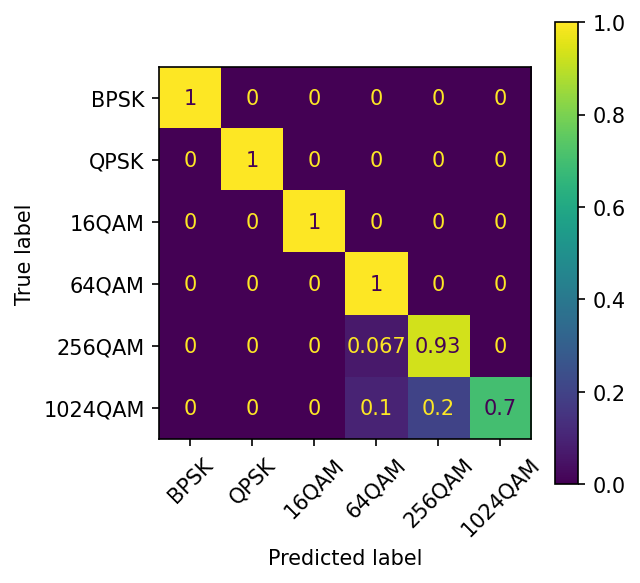

In [11]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# pred, target = getPredsWifi(valLoaderCumul, loadedWifiPskNet, loadedWifi16QamNet, loadedWifi64QamNet, loadedWifi256QamNet)
pred, target = getPredsWifi(valLoader, loadedWifiPskNet, loadedWifiQamNet)
# pred, target = getPreds(valLoader, loadedWifiPskNet)

# font = {'size'   : 15}
# plt.rc('font', **font)

cm = confusion_matrix(target,pred,normalize ='true')
for i in range(2):
    for j in range(2):
        cm[i, j] = round(cm[i, j], 2)

# cm[2, 0] = round(cm[2, 0], 2)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)

fig, ax = plt.subplots(figsize=(4,4), dpi =150)
disp.plot(ax=ax)

modNameList = []
for mod in modList[1]:        
    if mod == 2:
        # continue
        modul_name = 'BPSK'
    elif mod == 4:
        # continue
        modul_name = 'QPSK'
    elif mod == 16:
        # continue
        modul_name = '16QAM'
    elif mod == 64:
        # break
        # continue
        modul_name = '64QAM'
    elif mod == 256:
        # break
        modul_name = '256QAM'
    elif mod == 1024:
        # break
        modul_name = '1024QAM'

    modNameList.append(modul_name)
plt_labels = modNameList
ax.set_xticklabels(plt_labels, rotation=45)
ax.set_yticklabels(plt_labels)

In [29]:
SNRVec = np.arange(40, 41, 2, dtype=int)
FFTsize = 4096
tauVec = np.array([64, 256, 512, 1024, 2048])
CPLenList = [[16, 8], [64, 32, 16], [128, 36], [72], [144]]
CPOptList = np.array([np.array(['Extended', 'Normal']   ),\
    np.array(['Extended', 'Medium', 'Normal']),\
    np.array(['Extended', 'Normal']),\
    np.array(['Normal']), np.array(['Normal'])], dtype=object)
protocolList = np.array(['wlanHT', 'wlanHE', 'NRDLa', 'NRDLb', 'NRDLc'])

In [50]:
load_out = np.fromfile('/project/iarpa/dataset/cyclo_modul_OFDM/simulation/train/wlanHT/wlanHT_Extended_16qam/wlanHT_Extended_16_0_30_20_0.4_2.32cf',\
    dtype=np.float32)
f = open('/project/iarpa/dataset/cyclo_modul_OFDM/simulation/train/wlanHT/wlanHT_Extended_16qam/wlanHT_Extended_16_0_30_20_0.4_2.metadata')
loadMetadata = json.load(f)

data = load_out[np.arange(0, load_out.shape[0], 2)] +\
                    1j * load_out[np.arange(1, load_out.shape[0], 2)]

In [9]:
from torchsummary import summary
summary(loadedWifiNet, input_size=(1, 50, 50))

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.